In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import gudhi.weighted_rips_complex


In [2]:
distance_matrix = pd.read_csv("dmv_Symmetric_Distance_Matrix.csv", index_col=0).values
wait_vector = np.genfromtxt("dmv_waits.csv", delimiter=",")


In [3]:
# Create the weighted Vietoris–Rips complex
cpx = gd.weighted_rips_complex.WeightedRipsComplex(
    distance_matrix=distance_matrix,
    weights=wait_vector
).create_simplex_tree(max_dimension=2)  # computes up to 1D homology


In [4]:
# Compute persistent homology
cpx.compute_persistence()

# Extract birth/death pairs
ph = cpx.persistence()

# Convert birth/death times from seconds to minutes (more interpretable)
ph_minutes = [(dim, (b/60, d/60)) for dim, (b, d) in ph if d < float("inf")]


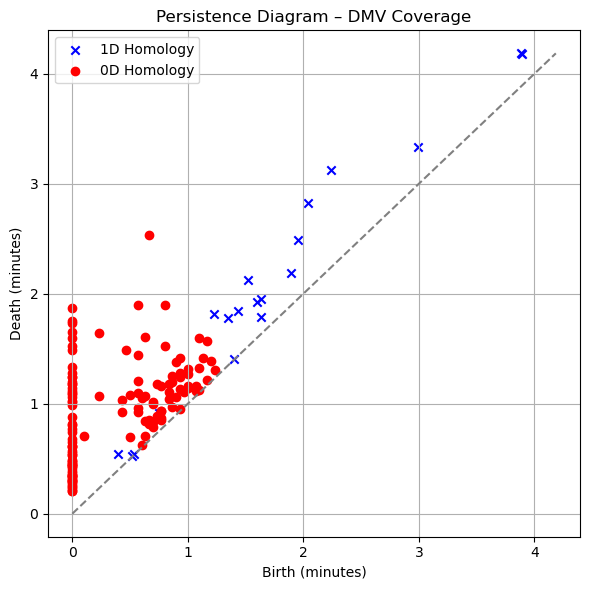

In [5]:
# Plot the persistence diagram
plt.figure(figsize=(6, 6))

for dim, (b, d) in ph_minutes:
    if dim == 0:
        plt.scatter(b, d, color='red', label='0D Homology' if '0D Homology' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif dim == 1:
        plt.scatter(b, d, color='blue', marker='x', label='1D Homology' if '1D Homology' not in plt.gca().get_legend_handles_labels()[1] else "")

# Diagonal reference line
max_val = max(d for _, (_, d) in ph_minutes)
plt.plot([0, max_val], [0, max_val], linestyle='--', color='gray')

# Labels and layout
plt.xlabel("Birth (minutes)")
plt.ylabel("Death (minutes)")
plt.title("Persistence Diagram – DMV Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
